In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import stats # for mode calculation
import seaborn as sns
from AdversarialExamples import AdversarialExamples

C:\Users\ari15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Lets train a new model!

In [3]:
model = AdversarialExamples.get_model()

C:\Users\ari15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Adversarial Learning: Generate adversarial examples and add them to the train data. Note that it is random noise, not generated from fgsm, because we don't know the gradient of the final model that we want to exploit

In [4]:
eps = 0.1
x_train_adv = x_train + eps * np.sign(np.random.rand(*x_train.shape) - 0.5)
x_train_adv = np.clip(x_train_adv, 0, 1)

In [5]:
# create datasets with augmentations

# Create the dataset from one-hot encoded labels
train_dataset = tf.data.Dataset.from_tensor_slices((np.concatenate([x_train, x_train_adv]), np.concatenate([y_train_one_hot, y_train_one_hot])))

# Apply augmentation, shuffle, batch, and prefetch
train_dataset = train_dataset.map(AdversarialExamples.augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=5000).batch(64).prefetch(tf.data.AUTOTUNE)

# create test dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test_one_hot))

In [ ]:
# Trained on Google Colab
# batch_size = 64
# history = model.fit(train_dataset, epochs=1,
#                     validation_data=(x_test, y_test_one_hot),
#                     batch_size=batch_size)

# loss, accuracy = model.evaluate(x_test, y_test_one_hot, verbose=1)
# print(loss, accuracy)

# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')

782/782 ━━━━━━━━━━━━━━━━━━━━ 67s 82ms/step - accuracy: 0.3543 - loss: 2.1311 - val_accuracy: 0.4936 - val_loss: 1.4760


We're done training!

In [4]:
original_model = AdversarialExamples.get_model()
original_model.load_weights('final/final.weights.h5')

adversarial_model = AdversarialExamples.get_model()
adversarial_model.load_weights('random_adversarial_learning/random_adversary_model.weights.h5')

loss, accuracy = original_model.evaluate(x_test, y_test_one_hot, verbose=1)
print(f"original model: {loss}, {accuracy}")

loss, accuracy = adversarial_model.evaluate(x_test, y_test_one_hot, verbose=1)
print(f"adversarial model: {loss}, {accuracy}")

C:\Users\ari15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ari15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8354 - loss: 0.4966
original model: 0.49297255277633667, 0.8348000049591064
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8223 - loss: 0.5226
adversarial model: 0.5241624712944031, 0.8203999996185303


Our new model is slightly worse on the unperturbed test set (looks more like noise). Let's test it on an adversarial dataset

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4510 - loss: 1.8580


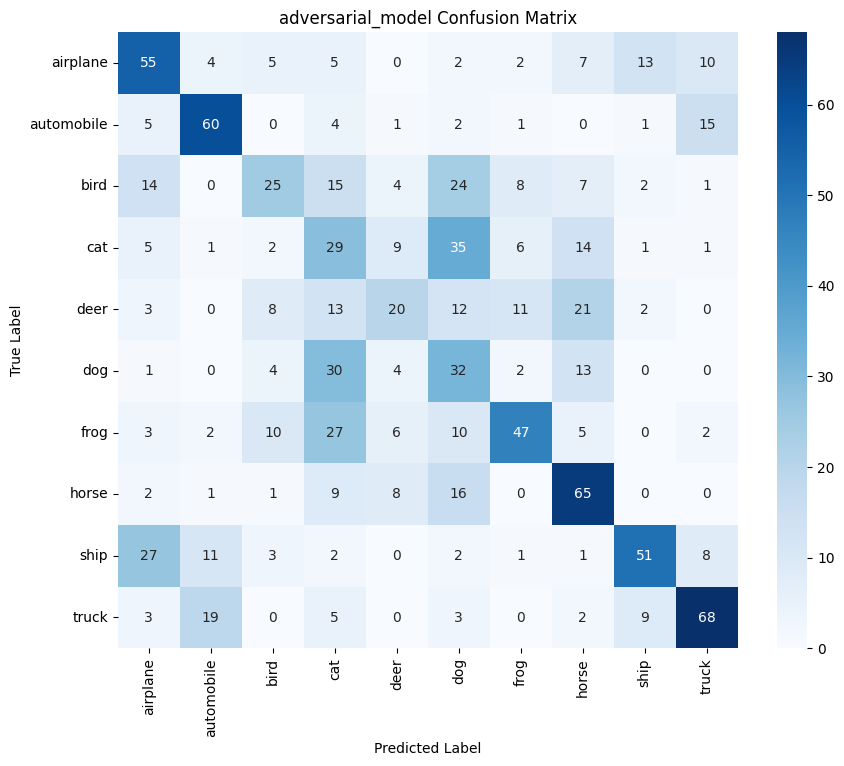

In [6]:
n=1000
x_adv_test = AdversarialExamples.create_fgsm_dataset(adversarial_model, x_test[:n], y_test_one_hot[:n], eps=0.01) # for eps=0.05, does not become all frogs :/
loss, accuracy = adversarial_model.evaluate(x_adv_test, y_test_one_hot[:n], verbose=1)

predictions = tf.argmax(adversarial_model(x_adv_test), axis=1)
conf_mat = tf.math.confusion_matrix(y_test[:n], predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("adversarial_model Confusion Matrix")
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0605 - loss: 6.9046


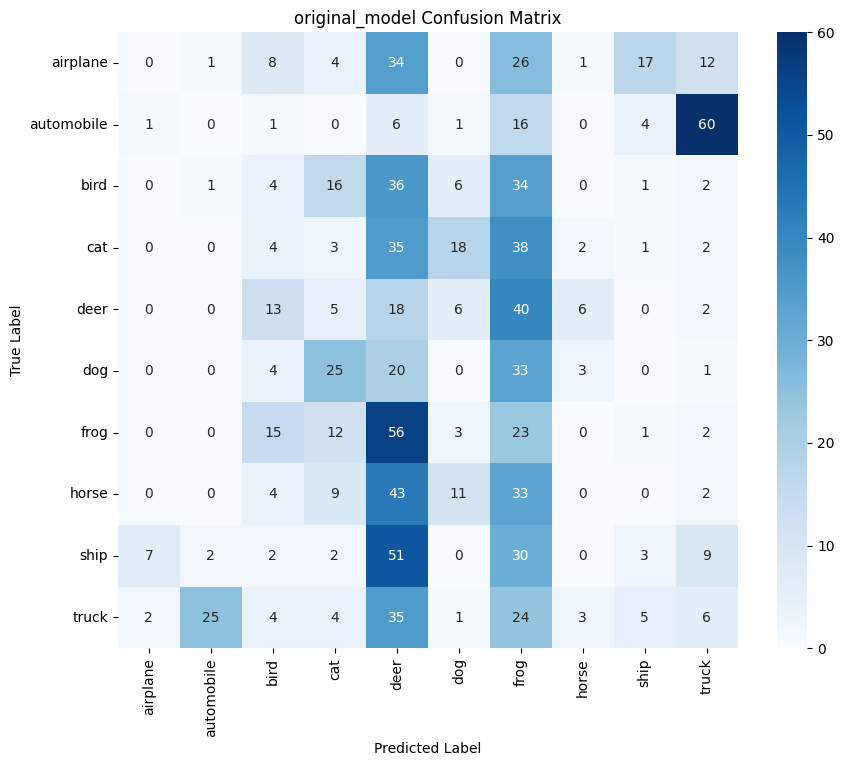

In [49]:
n = 1000
x_adv_test = AdversarialExamples.create_fgsm_dataset(original_model, x_test[:n], y_test_one_hot[:n], eps=0.05)
loss, accuracy = original_model.evaluate(x_adv_test, y_test_one_hot[:n], verbose=1)

predictions = tf.argmax(original_model(x_adv_test), axis=1)
conf_mat = tf.math.confusion_matrix(y_test[:n], predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("original_model Confusion Matrix")
plt.show()

20% improvement, from only data augmentation! Let's try using fgsm generated adversarial examples. However, since the model's parameters are constantly updated, let's update the fgsm examples every epoch

In [ ]:
fgsm_model = AdversarialExamples.get_model()
num_epochs = 1
eps = 0.01

def fgsm_perturbation(image, label):
    image = tf.expand_dims(image, axis=0) # batch size of 1
    label = tf.expand_dims(label, axis=0) # batch size of 1

    # get gradient
    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = fgsm_model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, predictions)
    gradients = tape.gradient(loss, image)

    # perturb image
    perturbed_image = image + eps * tf.sign(gradients)

    perturbed_image = tf.squeeze(perturbed_image, axis=0)  # Remove batch dimension
    label = tf.squeeze(label, axis=0)  # Remove batch dimension
    return perturbed_image, label

train_dataset = train_dataset.map(
    lambda x, y: (tf.cast(x, tf.float32), y), num_parallel_calls=tf.data.AUTOTUNE
)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_one_hot))
aug_train_dataset = train_dataset.map(AdversarialExamples.augment, num_parallel_calls=tf.data.AUTOTUNE)

base_train_dataset = train_dataset.concatenate(aug_train_dataset)


adv_train_dataset = train_dataset.map(fgsm_perturbation, num_parallel_calls=tf.data.AUTOTUNE)

for epoch in range(num_epochs):
    
    # update adversarial dataset
    adv_train_dataset = train_dataset.map(fgsm_perturbation, num_parallel_calls=tf.data.AUTOTUNE)

    # update current datset to have updated adversarial dataset
    cur_dataset = adv_train_dataset.concatenate(base_train_dataset)
    cur_dataset = cur_dataset.shuffle(buffer_size=5000).batch(64).prefetch(tf.data.AUTOTUNE)

    # train model for one epoch
    fgsm_model.fit(cur_dataset, validation_data=(x_test, y_test_one_hot), epochs=1, verbose=1)



 193/2344 ━━━━━━━━━━━━━━━━━━━━ 4:18 120ms/step - accuracy: 0.2503 - loss: 2.7345

KeyboardInterrupt: 

In [10]:
fgsm_model.load_weights('fgsm_adversarial_learning/fgsm_adversary_model.weights.h5')

loss, accuracy = fgsm_model.evaluate(x_test, y_test_one_hot, verbose=1)
print(f"fgsm model: {loss}, {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8358 - loss: 0.4764
fgsm model: 0.48395106196403503, 0.8331000208854675


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0385 - loss: 5.9502
5.963490009307861 0.039000000804662704


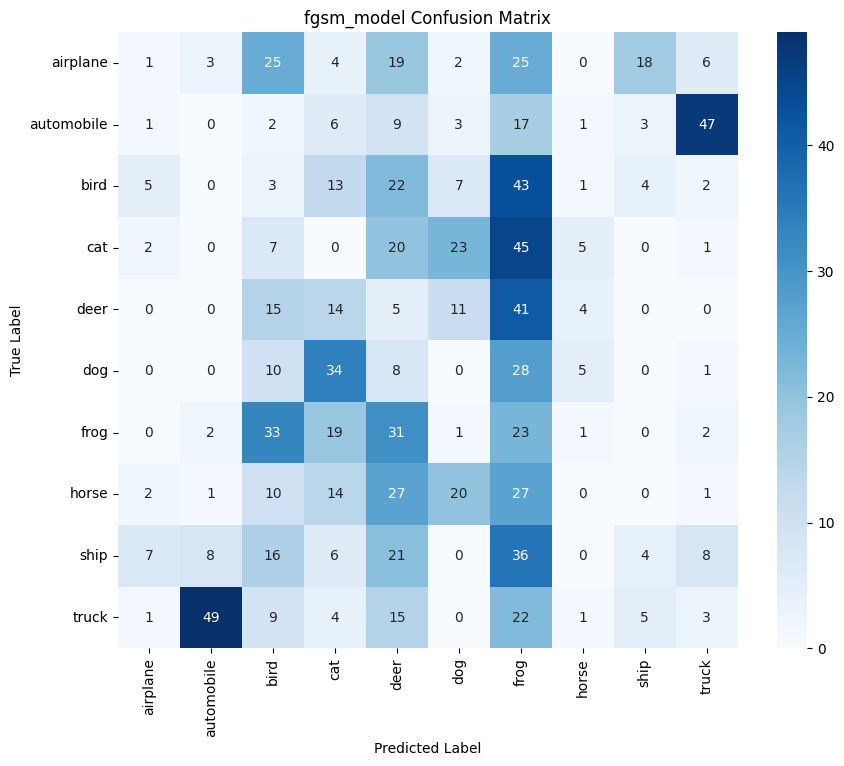

In [ ]:
n = 1000
x_adv_test = AdversarialExamples.create_fgsm_dataset(fgsm_model, x_test[:n], y_test_one_hot[:n], eps=0.01)
loss, accuracy = fgsm_model.evaluate(x_adv_test, y_test_one_hot[:n], verbose=1)
print(loss, accuracy)

predictions = tf.argmax(fgsm_model(x_adv_test), axis=1)
conf_mat = tf.math.confusion_matrix(y_test[:n], predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("fgsm_model Confusion Matrix")
plt.show()

In [ ]:
# what if we add random noise after the fgsm perturbation?
eps = 0.1
n = 100
random_x_test = AdversarialExamples.create_fgsm_dataset(adversarial_model, x_test[:n], y_test_one_hot[:n], eps=0.01)
for i in range(0, n):
    random_x_test[i] = random_x_test[i] + eps * AdversarialExamples.create_random_pattern(x_test[0].shape)

loss, accuracy = adversarial_model.evaluate(random_x_test[:n], y_test_one_hot[:n], verbose=1)
print(loss, accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6457 - loss: 1.2094 
1.2391352653503418 0.6299999952316284
